# ChemProp for NR-AhR Prediction on Tox21 Dataset

This notebook demonstrates how to use ChemProp (a message passing neural network for molecular property prediction) to predict NR-AhR (Nuclear Receptor - Aryl hydrocarbon Receptor) activity from the Tox21 dataset.

## Overview
- **Dataset**: Tox21 dataset containing molecular SMILES and toxicity endpoints
- **Target**: NR-AhR (Nuclear Receptor - Aryl hydrocarbon Receptor)
- **Method**: ChemProp - Message Passing Neural Networks for molecular property prediction
- **Task**: Binary classification (active/inactive)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import os
import tempfile
import subprocess
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Load the Tox21 dataset
tox21_path = "/u/shaswata/scratch/Learning/xAI_Drug/tox21.csv"
df = pd.read_csv(tox21_path)

print("Dataset shape:", df.shape)
print("\nDataset columns:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (7831, 14)

Dataset columns:
['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53', 'mol_id', 'smiles']

First few rows:


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


NR-AhR value counts:
NR-AhR
0.0    5781
NaN    1282
1.0     768
Name: count, dtype: int64

Percentage of missing values in NR-AhR: 16.37%

Percentage of missing values in SMILES: 0.00%


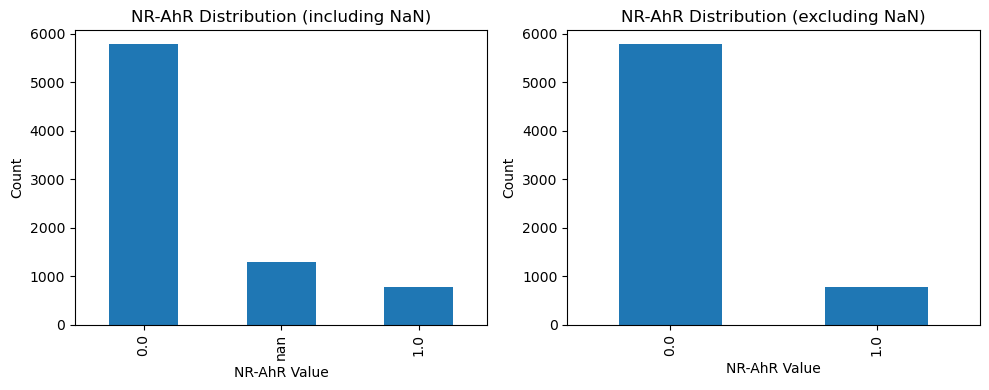

In [ ]:
# Explore the NR-AhR target variable
print("NR-AhR value counts:")
print(df['NR-AhR'].value_counts(dropna=False))
print(f"\nPercentage of missing values in NR-AhR: {df['NR-AhR'].isna().sum() / len(df) * 100:.2f}%")

# Check for missing values in SMILES
print(f"\nPercentage of missing values in SMILES: {df['smiles'].isna().sum() / len(df) * 100:.2f}%")

# Visualize the distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
df['NR-AhR'].value_counts(dropna=False).plot(kind='bar')
plt.title('NR-AhR Distribution (including NaN)')
plt.xlabel('NR-AhR Value')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['NR-AhR'].dropna().value_counts().plot(kind='bar')
plt.title('NR-AhR Distribution (excluding NaN)')
plt.xlabel('NR-AhR Value')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
# Data preprocessing for ChemProp
# ChemProp requires specific format: SMILES and target columns

# Filter out rows with missing NR-AhR values or missing SMILES
df_clean = df[['smiles', 'NR-AhR']].dropna()

print(f"Original dataset size: {len(df)}")
print(f"Clean dataset size: {len(df_clean)}")
print(f"Rows removed: {len(df) - len(df_clean)}")

# Check the distribution after cleaning
print(f"\nNR-AhR distribution in clean dataset:")
print(df_clean['NR-AhR'].value_counts())

# Check for unique SMILES
print(f"\nNumber of unique SMILES: {df_clean['smiles'].nunique()}")
print(f"Number of duplicate SMILES: {len(df_clean) - df_clean['smiles'].nunique()}")

df_clean.head()

Original dataset size: 7831
Clean dataset size: 6549
Rows removed: 1282

NR-AhR distribution in clean dataset:
NR-AhR
0.0    5781
1.0     768
Name: count, dtype: int64

Number of unique SMILES: 6549
Number of duplicate SMILES: 0


,smiles,NR-AhR
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,1.0
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0
5,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0.0


In [5]:
# Create train/test split
# ChemProp works with CSV files containing 'smiles' and target columns
train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=42, stratify=df_clean['NR-AhR'])

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
print(f"\nTraining set NR-AhR distribution:")
print(train_df['NR-AhR'].value_counts())
print(f"\nTest set NR-AhR distribution:")
print(test_df['NR-AhR'].value_counts())

# Create directories for ChemProp files
os.makedirs('chemprop_data', exist_ok=True)
os.makedirs('chemprop_models', exist_ok=True)

# Save train and test sets to CSV files (ChemProp format)
train_path = 'chemprop_data/train.csv'
test_path = 'chemprop_data/test.csv'

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print(f"\nTrain data saved to: {train_path}")
print(f"Test data saved to: {test_path}")

Training set size: 5239
Test set size: 1310

Training set NR-AhR distribution:
NR-AhR
0.0    4625
1.0     614
Name: count, dtype: int64

Test set NR-AhR distribution:
NR-AhR
0.0    1156
1.0     154
Name: count, dtype: int64

Train data saved to: chemprop_data/train.csv
Test data saved to: chemprop_data/test.csv


In [3]:
test = pd.read_csv("chemprop_data/test.csv")

In [5]:
pred = pd.read_csv("chemprop_data/predictions.csv")

In [13]:
pred

,smiles,NR-AhR
0,CCCCOCC(C)OCC(C)O,0.014245039783418179
1,N#Cc1c(F)cccc1F,0.040288154035806656
2,OCCOCCN1CCN(C2=Nc3ccccc3Sc3ccccc32)CC1.OCCOCCN...,0.0719175636768341
3,CCCC[n+]1ccc(C)cc1,0.011573364026844501
4,CC1=NN(c2ccc(S(=O)(=O)O)cc2)C(=O)C1,0.009945208206772804
...,...,...
1305,O=Cc1ccc(CO)o1,0.005493721924722195
1306,Cn1sccc1=O,0.009028710424900055
1307,Oc1ccc(CCNCCCCCCNCCc2ccccc2)cc1O,0.08152962476015091
1308,CCCCCCOC(=O)CCCCC(=O)OCCCCCC,0.012880937196314335


In [14]:
pred['NR-AhR'] = pred['NR-AhR'].astype(float)

ValueError: could not convert string to float: 'Invalid SMILES'

In [17]:
# Handle invalid SMILES in predictions
print("Checking and cleaning predictions data...")
print(f"Predictions shape: {pred.shape}")
print(f"Predictions columns: {pred.columns.tolist()}")

# Check for non-numeric values in the NR-AhR column
print(f"\nUnique values in NR-AhR predictions:")
print(pred['NR-AhR'].value_counts())

# Count invalid SMILES
invalid_count = (pred['NR-AhR'] == 'Invalid SMILES').sum()
print(f"\nNumber of 'Invalid SMILES' entries: {invalid_count}")

if invalid_count > 0:
    print(f"Percentage of invalid predictions: {invalid_count / len(pred) * 100:.2f}%")
    
    # Show which SMILES caused issues
    print("\nSMILES that caused 'Invalid SMILES' errors:")
    if 'smiles' in pred.columns:
        invalid_smiles = pred[pred['NR-AhR'] == 'Invalid SMILES']['smiles'].unique()
        for i, smile in enumerate(invalid_smiles[:5]):  # Show first 5
            print(f"  {i+1}. {smile}")
        if len(invalid_smiles) > 5:
            print(f"  ... and {len(invalid_smiles) - 5} more")
    
    # Remove invalid predictions
    print(f"\nRemoving {invalid_count} invalid predictions...")
    pred_clean = pred[pred['NR-AhR'] != 'Invalid SMILES'].copy()
    
    # Convert to float
    pred_clean['NR-AhR'] = pred_clean['NR-AhR'].astype(float)
    
    print(f"Clean predictions shape: {pred_clean.shape}")
    print(f"Predictions range: {pred_clean['NR-AhR'].min():.4f} to {pred_clean['NR-AhR'].max():.4f}")
    
    # Also need to filter the test set to match
    if 'smiles' in pred.columns:
        # Get the SMILES that have valid predictions
        valid_smiles = pred_clean['smiles'].tolist()
        test_clean = test[test['smiles'].isin(valid_smiles)].copy()
        test_clean = test_clean.reset_index(drop=True)
        pred_clean = pred_clean.reset_index(drop=True)
        
        print(f"Filtered test set shape: {test_clean.shape}")
        
        # Update variables for use in evaluation
        pred = pred_clean
        test = test_clean
    else:
        pred = pred_clean
        
else:
    # No invalid SMILES, just convert to float
    pred['NR-AhR'] = pred['NR-AhR'].astype(float)
    print("✓ All predictions are valid, converted to float successfully")

print(f"\nFinal predictions statistics:")
print(f"  Count: {len(pred)}")
print(f"  Mean: {pred['NR-AhR'].mean():.4f}")
print(f"  Std: {pred['NR-AhR'].std():.4f}")
print(f"  Min: {pred['NR-AhR'].min():.4f}")
print(f"  Max: {pred['NR-AhR'].max():.4f}")

Checking and cleaning predictions data...
Predictions shape: (1309, 2)
Predictions columns: ['smiles', 'NR-AhR']

Unique values in NR-AhR predictions:
NR-AhR
0.004807    2
0.008346    2
0.000235    2
0.004828    1
0.039025    1
           ..
0.001840    1
0.000206    1
0.004795    1
0.002732    1
0.124223    1
Name: count, Length: 1306, dtype: int64

Number of 'Invalid SMILES' entries: 0
✓ All predictions are valid, converted to float successfully

Final predictions statistics:
  Count: 1309
  Mean: 0.0918
  Std: 0.1728
  Min: 0.0000
  Max: 0.9147


MODEL PERFORMANCE EVALUATION
Dataset sizes:
  True labels: 1309
  Predictions: 1309
  Class distribution: {0.0: 1155, 1.0: 154}

=== MODEL PERFORMANCE ===
Accuracy: 0.9160
AUC-ROC: 0.9001

Classification Report:
              precision    recall  f1-score   support

    Inactive       0.92      0.99      0.95      1155
      Active       0.81      0.37      0.51       154

    accuracy                           0.92      1309
   macro avg       0.87      0.68      0.73      1309
weighted avg       0.91      0.92      0.90      1309



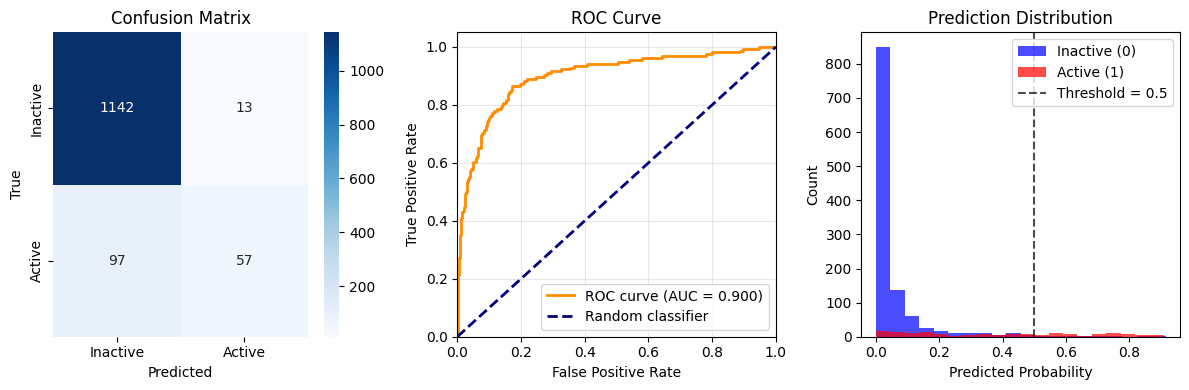


Example predictions:
                                              smiles  true_label  \
0                                  CCCCOCC(C)OCC(C)O         0.0   
1                                    N#Cc1c(F)cccc1F         0.0   
2  OCCOCCN1CCN(C2=Nc3ccccc3Sc3ccccc32)CC1.OCCOCCN...         0.0   
3                                 CCCC[n+]1ccc(C)cc1         1.0   
4                CC1=NN(c2ccc(S(=O)(=O)O)cc2)C(=O)C1         0.0   
5         CS(=O)(=O)Nc1ccc([N+](=O)[O-])cc1Oc1ccccc1         0.0   
6                      O=C(c1ccc(O)cc1O)c1ccc(O)cc1O         1.0   
7    CCN(C(=O)c1cc(C)cc(OC[C@H](C)Nc2ccncc2)c1)C(C)C         0.0   
8  O=C(O)c1cn(-c2ccc(F)cc2)c2cc(N3CCNCC3)c(F)cc2c1=O         0.0   
9                         CCN(CC)C(=O)SCc1ccc(Cl)cc1         0.0   

   predicted_prob  predicted_class  
0        0.014245                0  
1        0.040288                0  
2        0.071918                0  
3        0.011573                0  
4        0.009945                0  
5      

In [16]:
# Evaluate model performance with cleaned data
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 60)
print("MODEL PERFORMANCE EVALUATION")
print("=" * 60)

try:
    # Ensure we have matching test and prediction data
    if len(test) != len(pred):
        print(f"Warning: Mismatch in lengths - test: {len(test)}, predictions: {len(pred)}")
        
        # If we have SMILES in both, align them
        if 'smiles' in test.columns and 'smiles' in pred.columns:
            merged = pd.merge(test, pred, on='smiles', suffixes=('_true', '_pred'))
            y_true = merged['NR-AhR_true']
            y_prob = merged['NR-AhR_pred']
            print(f"Merged data shape: {len(merged)}")
        else:
            # If lengths don't match and no SMILES to align, take minimum length
            min_len = min(len(test), len(pred))
            y_true = test['NR-AhR'].iloc[:min_len]
            y_prob = pred['NR-AhR'].iloc[:min_len]
            print(f"Using first {min_len} samples from both datasets")
    else:
        y_true = test['NR-AhR']
        y_prob = pred['NR-AhR']
    
    # Convert probabilities to binary predictions (threshold = 0.5)
    y_pred = (y_prob >= 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    
    print(f"Dataset sizes:")
    print(f"  True labels: {len(y_true)}")
    print(f"  Predictions: {len(y_prob)}")
    print(f"  Class distribution: {pd.Series(y_true).value_counts().to_dict()}")
    
    print(f"\n=== MODEL PERFORMANCE ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Inactive', 'Active']))
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Inactive', 'Active'], 
                yticklabels=['Inactive', 'Active'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Plot ROC curve
    plt.subplot(1, 3, 2)
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    # Plot prediction distribution
    plt.subplot(1, 3, 3)
    plt.hist(y_prob[y_true == 0], bins=20, alpha=0.7, label='Inactive (0)', color='blue')
    plt.hist(y_prob[y_true == 1], bins=20, alpha=0.7, label='Active (1)', color='red')
    plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Threshold = 0.5')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.title('Prediction Distribution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Show some example predictions
    print(f"\nExample predictions:")
    if 'smiles' in test.columns:
        examples = pd.DataFrame({
            'smiles': test['smiles'].iloc[:10] if len(test) >= 10 else test['smiles'],
            'true_label': y_true.iloc[:10] if len(y_true) >= 10 else y_true,
            'predicted_prob': y_prob.iloc[:10] if len(y_prob) >= 10 else y_prob,
            'predicted_class': y_pred.iloc[:10] if len(y_pred) >= 10 else y_pred
        })
    else:
        examples = pd.DataFrame({
            'true_label': y_true.iloc[:10] if len(y_true) >= 10 else y_true,
            'predicted_prob': y_prob.iloc[:10] if len(y_prob) >= 10 else y_prob,
            'predicted_class': y_pred.iloc[:10] if len(y_pred) >= 10 else y_pred
        })
    print(examples)
    
except Exception as e:
    print(f"Error in evaluation: {e}")
    print("Please check that both test and prediction data are properly loaded and aligned.")